##### Copyright 2025 Google LLC.

In [ ]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Day 4 - Fine tuning a custom model

Welcome back to the Kaggle 5-day Generative AI course!

In this notebook you will use the Gemini API to fine-tune a custom, task-specific model. Fine-tuning can be used for a variety of tasks from classic NLP problems like entity extraction or summarisation, to creative tasks like stylised generation. You will fine-tune a model to classify the category a piece of text (a newsgroup post) into the category it belongs to (the newsgroup name).

This codelab walks you tuning a model with the API. [AI Studio](https://aistudio.google.com/app/tune) also supports creating new tuned models directly in the web UI, allowing you to quickly create and monitor models using data from Google Sheets, Drive or your own files.

**Note**: We recommend doing this codelab first today. There may be a period of waiting while the model tunes, so if you start with this one, you can try the other codelab while you wait.

In [1]:
!pip uninstall -qqy jupyterlab  # Remove unused conflicting packages
!pip install -U -q "google-genai==1.7.0"

In [2]:
from google import genai
from google.genai import types

genai.__version__

'1.7.0'

### Set up your API key

To run the following cell, your API key must be stored it in a [Kaggle secret](https://www.kaggle.com/discussions/product-feedback/114053) named `GOOGLE_API_KEY`.

If you don't already have an API key, you can grab one from [AI Studio](https://aistudio.google.com/app/apikey). You can find [detailed instructions in the docs](https://ai.google.dev/gemini-api/docs/api-key).

To make the key available through Kaggle secrets, choose `Secrets` from the `Add-ons` menu and follow the instructions to add your key or enable it for this notebook.

In [3]:
from kaggle_secrets import UserSecretsClient

GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")

client = genai.Client(api_key=GOOGLE_API_KEY)

If you received an error response along the lines of `No user secrets exist for kernel id ...`, then you need to add your API key via `Add-ons`, `Secrets` **and** enable it.

![Screenshot of the checkbox to enable GOOGLE_API_KEY secret](https://storage.googleapis.com/kaggle-media/Images/5gdai_sc_3.png)
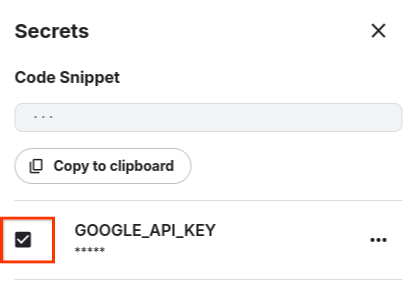

### Explore available models

You will be using the [`TunedModel.create`](https://ai.google.dev/api/tuning#method:-tunedmodels.create) API method to start the fine-tuning job and create your custom model. Find a model that supports it through the [`models.list`](https://ai.google.dev/api/models#method:-models.list) endpoint. You can also find more information about tuning models in [the model tuning docs](https://ai.google.dev/gemini-api/docs/model-tuning/tutorial?lang=python).

In [4]:
for model in client.models.list():
    if "createTunedModel" in model.supported_actions:
        print(model.name)

models/gemini-1.5-flash-001-tuning


## Download the dataset

In this activity, you will use the same newsgroups dataset that [you used to train a classifier in Keras](https://www.kaggle.com/code/markishere/day-2-classifying-embeddings-with-keras/). In this example you will use a fine-tuned Gemini model to achieve the same goal.

The [20 Newsgroups Text Dataset](https://scikit-learn.org/0.19/datasets/twenty_newsgroups.html) contains 18,000 newsgroups posts on 20 topics divided into training and test sets.

In [5]:
from sklearn.datasets import fetch_20newsgroups

newsgroups_train = fetch_20newsgroups(subset="train")
newsgroups_test = fetch_20newsgroups(subset="test")

# View list of class names for dataset
newsgroups_train.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [6]:
type(newsgroups_train)

sklearn.utils._bunch.Bunch

In [7]:
dir(newsgroups_train)


['DESCR', 'data', 'filenames', 'target', 'target_names']

In [8]:
print(newsgroups_train.data[15])

From: mathew <mathew@mantis.co.uk>
Subject: Re: <Political Atheists?
Organization: Mantis Consultants, Cambridge. UK.
X-Newsreader: rusnews v1.01
Lines: 22

kmr4@po.CWRU.edu (Keith M. Ryan) writes:
> ( I am almost sure that Zyklon-B is immediate and painless method of 
> death. If not, insert soem other form. )
> 
>         And, ethnic and minority groups have been killed, mutilated and 
> exterminated through out history, so I guess it was not unusual.
> 
>         So, you would agree that the holocost would be allowed under the US 
> Constitution?  [ in so far, the punishment. I doubt they recieved what would 
> be considered a "fair" trial by US standards.

Don't be so sure.  Look what happened to Japanese citizens in the US during
World War II.  If you're prepared to say "Let's round these people up and
stick them in a concentration camp without trial", it's only a short step to
gassing them without trial.  After all, it seems that the Nazis originally
only intended to imprison the

In [9]:
len(newsgroups_train.data)/len(newsgroups_test.data)

1.5021242697822623

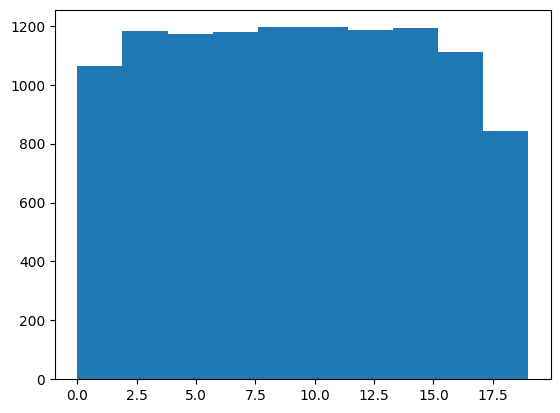

In [10]:
import matplotlib.pyplot as plt

plt.hist(newsgroups_train.target)
plt.show()

Here's what a single row looks like.

In [11]:
print(newsgroups_train.data[0])

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----







## Prepare the dataset

You'll use the same pre-processing code you used for the custom model on day 2. This pre-processing removes personal information, which can be used to "shortcut" to known users of a forum, and formats the text to appear a bit more like regular text and less like a newsgroup post (e.g. by removing the mail headers). This normalisation allows the model to generalise to regular text and not over-depend on specific fields. If your input data is always going to be newsgroup posts, it may be helpful to leave this structure in place if they provide genuine signals.

In [12]:
import email
import re

import pandas as pd


def preprocess_newsgroup_row(data):
    # Extract only the subject and body
    msg = email.message_from_string(data)
    text = f"{msg['Subject']}\n\n{msg.get_payload()}"
    # Strip any remaining email addresses
    text = re.sub(r"[\w\.-]+@[\w\.-]+", "", text)
    # Truncate the text to fit within the input limits
    text = text[:40000]

    return text


def preprocess_newsgroup_data(newsgroup_dataset):
    # Put data points into dataframe
    df = pd.DataFrame(
        {"Text": newsgroup_dataset.data, "Label": newsgroup_dataset.target}
    )
    # Clean up the text
    df["Text"] = df["Text"].apply(preprocess_newsgroup_row)
    # Match label to target name index
    df["Class Name"] = df["Label"].map(lambda l: newsgroup_dataset.target_names[l])

    return df

In [13]:
# Apply preprocessing to training and test datasets
df_train = preprocess_newsgroup_data(newsgroups_train)
df_test = preprocess_newsgroup_data(newsgroups_test)

df_train.head()

,Text,Label,Class Name
0,WHAT car is this!?\n\n I was wondering if anyo...,7,rec.autos
1,SI Clock Poll - Final Call\n\nA fair number of...,4,comp.sys.mac.hardware
2,"PB questions...\n\nwell folks, my mac plus fin...",4,comp.sys.mac.hardware
3,Re: Weitek P9000 ?\n\nRobert J.C. Kyanko () wr...,1,comp.graphics
4,Re: Shuttle Launch Question\n\nFrom article <>...,14,sci.space


Now sample the data. You will keep 50 rows for each category for training. Note that this is even fewer than the Keras example, as this technique (parameter-efficient fine-tuning, or PEFT) updates a relatively small number of parameters and does not require training a new model or updating the large model.

In [14]:
def sample_data(df, num_samples, classes_to_keep):
    # Sample rows, selecting num_samples of each Label.
    df = (
        df.groupby("Label")[df.columns]
        .apply(lambda x: x.sample(num_samples))
        .reset_index(drop=True)
    )

    df = df[df["Class Name"].str.contains(classes_to_keep)]
    df["Class Name"] = df["Class Name"].astype("category")

    return df


TRAIN_NUM_SAMPLES = 50
TEST_NUM_SAMPLES = 10
# Keep rec.* and sci.*
CLASSES_TO_KEEP = "^rec|^sci"

df_train = sample_data(df_train, TRAIN_NUM_SAMPLES, CLASSES_TO_KEEP)
df_test = sample_data(df_test, TEST_NUM_SAMPLES, CLASSES_TO_KEEP)

In [15]:
print(set(list(df_train['Label'])), len(df_train))


{7, 8, 9, 10, 11, 12, 13, 14} 400


In [16]:
print(set(list(df_test['Label'])), len(df_test))

{7, 8, 9, 10, 11, 12, 13, 14} 80


## Evaluate baseline performance

Before you start tuning a model, it's good practice to perform an evaluation on the available models to ensure you can measure how much the tuning helps.

First identify a single sample row to use for visual inspection.

In [17]:
sample_idx = 0
sample_row = preprocess_newsgroup_row(newsgroups_test.data[sample_idx])
sample_label = newsgroups_test.target_names[newsgroups_test.target[sample_idx]]

print(sample_row)
print('---')
print('Label:', sample_label)

Need info on 88-89 Bonneville


 I am a little confused on all of the models of the 88-89 bonnevilles.
I have heard of the LE SE LSE SSE SSEI. Could someone tell me the
differences are far as features or performance. I am also curious to
know what the book value is for prefereably the 89 model. And how much
less than book value can you usually get them for. In other words how
much are they in demand this time of year. I have heard that the mid-spring
early summer is the best time to buy.

			Neil Gandler

---
Label: rec.autos


Passing the text directly in as a prompt does not yield the desired results. The model will attempt to respond to the message.

In [18]:
response = client.models.generate_content(
    model="gemini-1.5-flash-001", contents=sample_row)
print(response.text)

You're right, the Bonneville lineup in 1988 and 1989 could be confusing! Here's a breakdown to help you navigate:

**Bonneville Models & Differences:**

* **Base Bonneville:** The standard model. It came with a 3.8L V6 engine and basic features.
* **LE (Luxury Edition):**  A step up from the base model with more luxurious features, such as velour upholstery, power windows, and a premium sound system.
* **SE (Special Edition):**  Offered for a limited time. It included sporty styling cues and a performance-tuned suspension, though still powered by the 3.8L V6. 
* **LSE (Luxury Special Edition):**  Combined the luxury of the LE with some of the sporty styling of the SE.
* **SSE (Special Sport Edition):** The first Bonneville to offer a V8 engine, a 5.0L V8 to be precise. It also featured a firmer suspension and sport-oriented styling.
* **SSEi (Special Sport Edition Injected):**  Introduced in 1989. This model was essentially an SSE with a fuel-injected version of the 5.0L V8, resulting 

You can use the prompt engineering techniques you have learned this week to induce the model to perform the desired task. Try some of your own ideas and see what is effective, or check out the following cells for different approaches. Note that they have different levels of effectiveness!

In [19]:
# Ask the model directly in a zero-shot prompt.

prompt = "From what newsgroup does the following message originate?"
baseline_response = client.models.generate_content(
    model="gemini-1.5-flash-001",
    contents=[prompt, sample_row])
print(baseline_response.text)

The message originates from the **rec.autos.buick** newsgroup. This is evident from the subject line, which often includes the newsgroup name. 

The message also references a specific car model (Bonneville) and the year, both typical topics discussed in car-related newsgroups. 



This technique still produces quite a verbose response. You could try and parse out the relevant text, or refine the prompt even further.

In [20]:
from google.api_core import retry

# You can use a system instruction to do more direct prompting, and get a
# more succinct answer.

system_instruct = """
You are a classification service. You will be passed input that represents
a newsgroup post and you must respond with the newsgroup from which the post
originates.
"""

# Define a helper to retry when per-minute quota is reached.
is_retriable = lambda e: (isinstance(e, genai.errors.APIError) and e.code in {429, 503})

# If you want to evaluate your own technique, replace this body of this function
# with your model, prompt and other code and return the predicted answer.
@retry.Retry(predicate=is_retriable)
def predict_label(post: str) -> str:
    response = client.models.generate_content(
        model="gemini-1.5-flash-001",
        config=types.GenerateContentConfig(
            system_instruction=system_instruct),
        contents=post)

    rc = response.candidates[0]

    # Any errors, filters, recitation, etc we can mark as a general error
    if rc.finish_reason.name != "STOP":
        return "(error)"
    else:
        # Clean up the response.
        return response.text.strip()


prediction = predict_label(sample_row)

print(prediction)
print()
print("Correct!" if prediction == sample_label else "Incorrect.")

rec.autos.misc

Incorrect.


Now run a short evaluation using the function defined above. The test set is further sampled to ensure the experiment runs smoothly on the API's free tier. In practice you would evaluate over the whole set.

In [21]:
import tqdm
from tqdm.rich import tqdm as tqdmr
import warnings

# Enable tqdm features on Pandas.
tqdmr.pandas()

# But suppress the experimental warning
warnings.filterwarnings("ignore", category=tqdm.TqdmExperimentalWarning)


# Further sample the test data to be mindful of the free-tier quota.
df_baseline_eval = sample_data(df_test, 2, '.*')

# Make predictions using the sampled data.
df_baseline_eval['Prediction'] = df_baseline_eval['Text'].progress_apply(predict_label)

# And calculate the accuracy.
accuracy = (df_baseline_eval["Class Name"] == df_baseline_eval["Prediction"]).sum() / len(df_baseline_eval)
print(f"Accuracy: {accuracy:.2%}")

Output()

Accuracy: 18.75%


In [22]:
df_baseline_eval

,Text,Label,Class Name,Prediction
0,service indicator of a BMW\n\n\nDoes anyone kn...,7,rec.autos,rec.autos.bmw
1,Re: Ultimate AWD vehicles\n\nIn article <> wr...,7,rec.autos,rec.autos.makers.audi
2,"Re: A Kinder, Gentler BMW Mailing List\n\n (Bo...",8,rec.motorcycles,rec.motorcycles.bmw
3,"Re: Countersteering sans Hands\n\nIn article ,...",8,rec.motorcycles,rec.motorcycles
4,Re: Some baseball trivia\n\nIn article <> (Ph...,9,rec.sport.baseball,rec.sports.baseball
5,Re: Bases loaded walk gives Reds win in 12\n\n...,9,rec.sport.baseball,rec.sport.baseball
6,College hockey all-star game roster\n\nSomeone...,10,rec.sport.hockey,rec.sport.hockey
7,Re: Winnipeg vs. Vancouver\n\nIn article <> (...,10,rec.sport.hockey,alt.hockey.nhl.jets
8,"Re: I have seen the lobby, and it is us\n\nhIn...",11,sci.crypt,(error)
9,Re: political point of attack: Clipper infrast...,11,sci.crypt,(error)


In [23]:
print(3*100/16, "% accuracy.  --> 'rec.sports\..*' is different from 'rec.sport\..*'")

18.75 % accuracy.  --> 'rec.sports\..*' is different from 'rec.sport\..*'


Now take a look at the dataframe to compare the predictions with the labels.

In [24]:
df_baseline_eval

,Text,Label,Class Name,Prediction
0,service indicator of a BMW\n\n\nDoes anyone kn...,7,rec.autos,rec.autos.bmw
1,Re: Ultimate AWD vehicles\n\nIn article <> wr...,7,rec.autos,rec.autos.makers.audi
2,"Re: A Kinder, Gentler BMW Mailing List\n\n (Bo...",8,rec.motorcycles,rec.motorcycles.bmw
3,"Re: Countersteering sans Hands\n\nIn article ,...",8,rec.motorcycles,rec.motorcycles
4,Re: Some baseball trivia\n\nIn article <> (Ph...,9,rec.sport.baseball,rec.sports.baseball
5,Re: Bases loaded walk gives Reds win in 12\n\n...,9,rec.sport.baseball,rec.sport.baseball
6,College hockey all-star game roster\n\nSomeone...,10,rec.sport.hockey,rec.sport.hockey
7,Re: Winnipeg vs. Vancouver\n\nIn article <> (...,10,rec.sport.hockey,alt.hockey.nhl.jets
8,"Re: I have seen the lobby, and it is us\n\nhIn...",11,sci.crypt,(error)
9,Re: political point of attack: Clipper infrast...,11,sci.crypt,(error)


## Tune a custom model

In this example you'll use tuning to create a model that requires no prompting or system instructions and outputs succinct text from the classes you provide in the training data.

The data contains both input text (the processed posts) and output text (the category, or newsgroup), that you can use to start tuning a model.

When calling `tune()`, you can specify model tuning hyperparameters too:
 - `epoch_count`: defines how many times to loop through the data,
 - `batch_size`: defines how many rows to process in a single step, and
 - `learning_rate`: defines the scaling factor for updating model weights at each step.

You can also choose to omit them and use the defaults. [Learn more](https://developers.google.com/machine-learning/crash-course/linear-regression/hyperparameters) about these parameters and how they work. For this example these parameters were selected by running some tuning jobs and selecting parameters that converged efficiently.

This example will start a new tuning job, but only if one does not already exist. This allows you to leave this codelab and come back later - re-running this step will find your last model.

In [25]:
from collections.abc import Iterable
import random


# Convert the data frame into a dataset suitable for tuning.
input_data = {'examples': 
    df_train[['Text', 'Class Name']]
      .rename(columns={'Text': 'textInput', 'Class Name': 'output'})
      .to_dict(orient='records')
 }

# If you are re-running this lab, add your model_id here.
model_id = None

# Or try and find a recent tuning job.
if not model_id:
  queued_model = None
  # Newest models first.
  for m in reversed(client.tunings.list()):
    # Only look at newsgroup classification models.
    if m.name.startswith('tunedModels/newsgroup-classification-model'):
      # If there is a completed model, use the first (newest) one.
      if m.state.name == 'JOB_STATE_SUCCEEDED':
        model_id = m.name
        print('Found existing tuned model to reuse.')
        break

      elif m.state.name == 'JOB_STATE_RUNNING' and not queued_model:
        # If there's a model still queued, remember the most recent one.
        queued_model = m.name
  else:
    if queued_model:
      model_id = queued_model
      print('Found queued model, still waiting.')


# Upload the training data and queue the tuning job.
if not model_id:
    tuning_op = client.tunings.tune(
        base_model="models/gemini-1.5-flash-001-tuning",
        training_dataset=input_data,
        config=types.CreateTuningJobConfig(
            tuned_model_display_name="Newsgroup classification model",
            batch_size=16,
            epoch_count=2,
        ),
    )

    print(tuning_op.state)
    model_id = tuning_op.name

print(model_id)

Found queued model, still waiting.
tunedModels/newsgroup-classification-model-lorhtitz2


In [26]:
print(len(input_data['examples']))


400


In [27]:
indexes = [random.randint(0,400) for _ in range(10)]
for i in indexes:
    print(input_data['examples'][i]['output'])

rec.sport.baseball
rec.sport.baseball
rec.sport.hockey
sci.crypt
rec.autos
sci.med
sci.electronics
rec.autos
rec.autos
rec.sport.baseball


This has created a tuning job that will run in the background. To inspect the progress of the tuning job, run this cell to plot the current status and loss curve. Once the status reaches `ACTIVE`, tuning is complete and the model is ready to use.

Tuning jobs are queued, so it may look like no training steps have been taken initially but it will progress. Tuning can take anywhere from a few minutes to multiple hours, depending on factors like your dataset size and how busy the tuning infrastrature is. Why not treat yourself to a nice cup of tea while you wait, or come and say "Hi!" in the group [Discord](https://discord.com/invite/kaggle).

It is safe to stop this cell at any point. It will not stop the tuning job.

**IMPORTANT**: Due to the high volume of users doing this course, tuning jobs may be queued for many hours. Take a note of your tuned model ID above (`tunedModels/...`) so you can come back to it tomorrow. In the meantime, check out the [Search grounding](https://www.kaggle.com/code/markishere/day-4-google-search-grounding/) codelab. If you want to try tuning a local LLM, check out [the fine-tuning guides for tuning a Gemma model](https://ai.google.dev/gemma/docs/tune).

In [28]:
import datetime
import time


MAX_WAIT = datetime.timedelta(minutes=10)

while not (tuned_model := client.tunings.get(name=model_id)).has_ended:

    print(tuned_model.state)
    time.sleep(60)

    # Don't wait too long. Use a public model if this is going to take a while.
    if datetime.datetime.now(datetime.timezone.utc) - tuned_model.create_time > MAX_WAIT:
        print("Taking a shortcut, using a previously prepared model.")
        model_id = "tunedModels/newsgroup-classification-model-ltenbi1b"
        tuned_model = client.tunings.get(name=model_id)
        break


print(f"Done! The model state is: {tuned_model.state.name}")

if not tuned_model.has_succeeded and tuned_model.error:
    print("Error:", tuned_model.error)

JobState.JOB_STATE_RUNNING
Taking a shortcut, using a previously prepared model.
Done! The model state is: JOB_STATE_SUCCEEDED


## Use the new model

Now that you have a tuned model, try it out with custom data. You use the same API as a normal Gemini API interaction, but you specify your new model as the model name, which will start with `tunedModels/`.

In [29]:
new_text = """
First-timer looking to get out of here.

Hi, I'm writing about my interest in travelling to the outer limits!

What kind of craft can I buy? What is easiest to access from this 3rd rock?

Let me know how to do that please.
"""

response = client.models.generate_content(
    model=model_id, contents=new_text)

print(response.text)

sci.space


### Evaluation

You can see that the model outputs labels that correspond to those in the training data, and without any system instructions or prompting, which is already a great improvement. Now see how well it performs on the test set.

Note that there is no parallelism in this example; classifying the test sub-set will take a few minutes.

In [30]:
@retry.Retry(predicate=is_retriable)
def classify_text(text: str) -> str:
    """Classify the provided text into a known newsgroup."""
    response = client.models.generate_content(
        model=model_id, contents=text)
    rc = response.candidates[0]

    # Any errors, filters, recitation, etc we can mark as a general error
    if rc.finish_reason.name != "STOP":
        return "(error)"
    else:
        return rc.content.parts[0].text


# The sampling here is just to minimise your quota usage. If you can, you should
# evaluate the whole test set with `df_model_eval = df_test.copy()`.
#df_model_eval = sample_data(df_test, 4, '.*')
df_model_eval = df_test.copy()

df_model_eval["Prediction"] = df_model_eval["Text"].progress_apply(classify_text)

accuracy = (df_model_eval["Class Name"] == df_model_eval["Prediction"]).sum() / len(df_model_eval)
print(f"Accuracy: {accuracy:.2%}")

Output()

Accuracy: 87.50%


In [31]:
len(df_test)

80

In [32]:
df_model_eval

,Text,Label,Class Name,Prediction
70,Re: Manual Xmission-Advice needed...\n\n I don...,7,rec.autos,rec.autos
71,Re: water in trunk of 89 Probe??\n\nIn article...,7,rec.autos,rec.autos
72,Re: V4 V6 V8 V12 Vx?\n\n\nIn a previous articl...,7,rec.autos,rec.autos
73,Re: Ultimate AWD vehicles\n\nIn article <> wr...,7,rec.autos,rec.autos
74,Re: service indicator of a BMW\n\nSave youself...,7,rec.autos,rec.autos
...,...,...,...,...
145,No. Re: Space Marketing would be wonderfull.\n...,14,sci.space,sci.space
146,Electronic Journal of the ASA (EJASA) - April ...,14,sci.space,sci.space
147,Re: Vandalizing the sky.\n\n (Robert Bunge) wr...,14,sci.space,sci.space
148,Internet resources\n\nexit\n\n\n\n,14,sci.space,sci.crypt


## Compare token usage

AI Studio and the Gemini API provide model tuning at no cost, however normal limits and charges apply for *use* of a tuned model.

The size of the input prompt and other generation config like system instructions, as well as the number of generated output tokens, all contribute to the overall cost of a request.

In [33]:
# Calculate the *input* cost of the baseline model with system instructions.
sysint_tokens = client.models.count_tokens(
    model='gemini-1.5-flash-001', contents=[system_instruct, sample_row]
).total_tokens
print(f'System instructed baseline model: {sysint_tokens} (input)')

# Calculate the input cost of the tuned model.
tuned_tokens = client.models.count_tokens(model=tuned_model.base_model, contents=sample_row).total_tokens
print(f'Tuned model: {tuned_tokens} (input)')

savings = (sysint_tokens - tuned_tokens) / tuned_tokens
print(f'Token savings: {savings:.2%}')  # Note that this is only n=1.

System instructed baseline model: 172 (input)
Tuned model: 136 (input)
Token savings: 26.47%


The earlier verbose model also produced more output tokens than needed for this task.

In [34]:
baseline_token_output = baseline_response.usage_metadata.candidates_token_count
print('Baseline (verbose) output tokens:', baseline_token_output)

tuned_model_output = client.models.generate_content(
    model=model_id, contents=sample_row)
tuned_tokens_output = tuned_model_output.usage_metadata.candidates_token_count
print('Tuned output tokens:', tuned_tokens_output)

Baseline (verbose) output tokens: 61
Tuned output tokens: 3


## Next steps

Now that you have tuned a classification model, try some other tasks, like tuning a model to respond with a specific tone or style using hand-written examples (or even generated examples!). Kaggle hosts [a number of datasets](https://www.kaggle.com/datasets) you can try out.

Learn about [when supervised fine-tuning is most effective](https://cloud.google.com/blog/products/ai-machine-learning/supervised-fine-tuning-for-gemini-llm).

And check out the [fine-tuning tutorial](https://ai.google.dev/gemini-api/docs/model-tuning/tutorial?hl=en&lang=python) for another example that shows a tuned model extending beyond the training data to new, unseen inputs.

*- [Mark McD](https://linktr.ee/markmcd)*